In [195]:
import numpy as np
import scanpy as sc
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import scanpy as sc
import pandas as pd
import glob
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import ks_2samp

In [209]:
def kl_divergence(p, q):
    return np.sum(np.where((p != 0) & (q != 0), p * np.log(p / q), 0))
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (stats.entropy(p, m) + stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

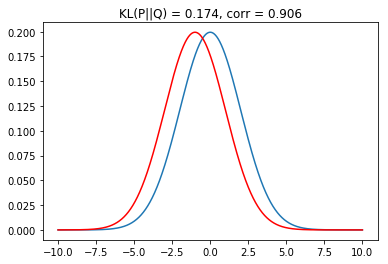

In [280]:
x = np.arange(-10, 10, 0.001)
p = norm.pdf(x, 0, 2)
q = norm.pdf(x, -1, 2)
plt.title(f'KL(P||Q) = {jensen_shannon_distance(p, q):1.3f}, corr = {pearsonr(p,q)[0]:1.3f}')
plt.plot(x, p)
plt.plot(x, q, c='red')

In [26]:
data_dict = {}
gene_list = []
for f in tqdm_notebook(glob.glob("/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/*")):
    data = sc.read_h5ad(f)
    f = f.replace('/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/','').replace('.h5ad','')
#     sc.pp.filter_cells(data, min_genes=5)
#     sc.pp.filter_genes(data, min_counts=50)
    #sc.pp.normalize_total(data)
    data_dict[f] = data
    gene_list = data.var_names

In [257]:
combined = {}
s = 1
for sample in sorted(data_dict):
    sample_name = '_'.join(sample.split('_')[:3])
    combined[sample_name] = np.log10(
        np.sum(data_dict[sample].X.toarray(), axis=1) + 1)
    combined[sample_name] = gaussian_filter1d(
        np.histogram(combined[sample_name], bins=100, density=True)[0], s)

In [234]:
global_min = np.min([np.min(combined[x]) for x in combined.keys()])
global_max = np.max([np.max(combined[x]) for x in combined.keys()])
n_bins = 50
step = (global_max - global_min) / n_bins
for i in range(n_bins):
    left = global_min + i * step
    right = global_min + (i+1) * step
    j = 0
    for sample in sorted(combined.keys()):
        res[i, j] = np.sum(((combined[sample] >= left) & (combined[sample] < right)))
        j += 1
res = pd.DataFrame(res, columns=sorted(combined.keys()))
res = res.apply(lambda x:x/np.sum(x), axis=0)
res = res.apply(lambda x:gaussian_filter1d(x, 2), axis=0)

In [214]:
ks_2samp(res['D1A_FA3_THA'], res['D1B_FA3_THA'])

Ks_2sampResult(statistic=0.18, pvalue=0.3959398631708505)

In [203]:
ks_2samp(res['D4X_FA3_FRE'], res['D4X_FA3_THA'])

Ks_2sampResult(statistic=0.32, pvalue=0.011511738725894704)

In [258]:
jensen_shannon_distance(combined['D1A_FA3_THA'], combined['D1B_FA3_THA'])

0.2182415801668931

In [275]:
print(jensen_shannon_distance(combined['D1A_FA3_THA'], combined['D1B_FA3_THA']))
print(jensen_shannon_distance(combined['D1A_FA3_THA'], combined['D1X_FA3_FRE']))
print(jensen_shannon_distance(combined['D1B_FA3_THA'], combined['D1X_FA3_FRE']))
print(jensen_shannon_distance(combined['D1X_FA2_THA'], combined['D1X_FA2_FRE']))
print(jensen_shannon_distance(combined['D4X_FA2_FRE'], combined['D4X_FA2_THA']))
print(jensen_shannon_distance(combined['D4X_FA3_FRE'], combined['D4X_FA3_THA']))

0.2182415801668931
0.19846215622636876
0.15265731190675338
0.1821091763627629
0.1878891611287712
0.1993071654990308


In [273]:
print(stats.wasserstein_distance(combined['D1A_FA3_THA'], combined['D1B_FA3_THA']))
print(stats.wasserstein_distance(combined['D1A_FA3_THA'], combined['D1X_FA3_FRE']))
print(stats.wasserstein_distance(combined['D1B_FA3_THA'], combined['D1X_FA3_FRE']))
print(stats.wasserstein_distance(combined['D1X_FA2_THA'], combined['D1X_FA2_FRE']))
print(stats.wasserstein_distance(combined['D4X_FA2_FRE'], combined['D4X_FA2_THA']))
print(stats.wasserstein_distance(combined['D4X_FA3_FRE'], combined['D4X_FA3_THA']))

0.05934266324575063
0.13230193412319596
0.13820544055876782
0.0784208241825218
0.08252126021057812
0.08060597678209064


In [281]:
print(kl_divergence(combined['D1A_FA3_THA'], combined['D1B_FA3_THA']))
print(kl_divergence(combined['D1X_FA3_FRE'], combined['D1A_FA3_THA']))
print(kl_divergence(combined['D1X_FA3_FRE'], combined['D1B_FA3_THA']))
print(kl_divergence(combined['D1X_FA2_FRE'], combined['D1X_FA2_THA']))
print(kl_divergence(combined['D4X_FA2_FRE'], combined['D4X_FA2_THA']))
print(kl_divergence(combined['D4X_FA3_FRE'], combined['D4X_FA3_THA']))

8.086869367908204
5.459743490850042
4.4160347075973005
9.00620868262069
15.612986019274937
4.125066510454135


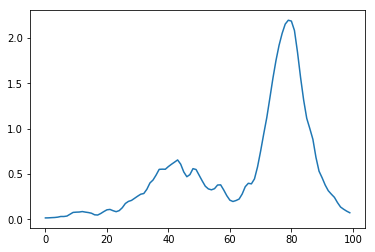

In [272]:
plt.plot(range(combined['D1A_FA3_THA'].shape[0]),combined['D1A_FA3_THA'])

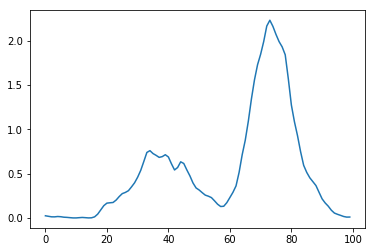

In [271]:
plt.plot(range(combined['D1B_FA3_THA'].shape[0]),combined['D1B_FA3_THA'])